# Static Covariates with TFT
In this notebook, we show three examples of how to use static covariates with the `TFTModel`.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
import pandas as pd
import numpy as np
from darts.utils.timeseries_generation import linear_timeseries,  random_walk_timeseries
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from darts.metrics import mape, mae
from darts.dataprocessing.transformers import Scaler
from datetime import timedelta
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

/home/ibojarovska/git_repositories/darts/venv-darts/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Simplest Toy Example
This example is very simple and "hand-written", to allow good understanding on how we can incorporate static covariates in a model in a simple way.

We assume we have two time series that we want to predict (each with values of a specific target for one country), and we would like to add two covariates that will capture the country differences. Then we want to train one model on the list of timeseries, and finally predict the future values for each of the time series separately. In the second example, we generalize this case to N timeseries instead of only two.

In [4]:
# create two time series that we want to forecast
ser_len = 360
pred_len = 35
series_DE = linear_timeseries(length=ser_len, column_name = 'DE')
series_AT = linear_timeseries(length=ser_len, column_name = 'AT')

In [5]:
# add country specific static covariates
static_covs_DE = pd.DataFrame([[1., 0.]], columns=["DE", "AT"])
static_covs_AT = pd.DataFrame([[0., 1.]], columns=["DE", "AT"])
series_DE = series_DE.with_static_covariates(static_covs_DE)
series_AT = series_AT.with_static_covariates(static_covs_AT)

In [6]:
# check the static covariates
series_DE.static_covariates

static_covariates,DE,AT
component,,
DE,1.0,0.0


In [7]:
# create some future covariates (two for each time series)
covariates_DE = linear_timeseries(length=ser_len, column_name = 'cov_1_DE')
covariates_DE = covariates_DE.stack(linear_timeseries(length=ser_len, column_name = 'cov_2_DE'))
covariates_AT = linear_timeseries(length=ser_len, column_name = 'cov_AT')
covariates_AT = covariates_AT.stack(linear_timeseries(length=ser_len, column_name = 'cov_2_DE'))

In [8]:
# add static covariates also for them
static_covs_DE = pd.DataFrame([[1., 0.], [1., 0.]], columns=["DE", "AT"])
static_covs_AT = pd.DataFrame([[0., 1.], [0., 1.]], columns=["DE", "AT"])
covariates_DE = covariates_DE.with_static_covariates(static_covs_DE)
covariates_AT = covariates_AT.with_static_covariates(static_covs_AT)

In [9]:
# set aside the last X days as a test series
train_DE, test_DE = series_DE[:-pred_len], series_DE[-pred_len:]
train_AT, test_AT = series_AT[:-pred_len], series_AT[-pred_len:]

### Create a model

In [10]:
# create a model
quantiles = [0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]

model = TFTModel(input_chunk_length = 7,
                     output_chunk_length = 7,
                     hidden_size=64,
                     n_epochs = 2, 
                     lstm_layers=2,
                     num_attention_heads=8,
                     dropout=0.1,
                     batch_size=32,
                     likelihood=QuantileRegression(quantiles=quantiles)
                )

### Train the TFT

In [11]:
model.fit(series=[train_DE, train_AT], future_covariates=[covariates_DE, covariates_AT], verbose=True) 

2022-07-16 09:34:49 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-16 09:34:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-16 09:34:49 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-16 09:34:49 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-07-16 09:34:49 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | static_covariates_vsn             | _VariableSelectionNetwork        | 3.3 K 
3  | encoder_vsn                       | _VariableSelectionNetwork        | 5.2 K 
4  | decoder_vsn        

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.55it/s, loss=0.195, train_loss=0.123]


### Look at plots of the predictions on the test set

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00, -7.20it/s]


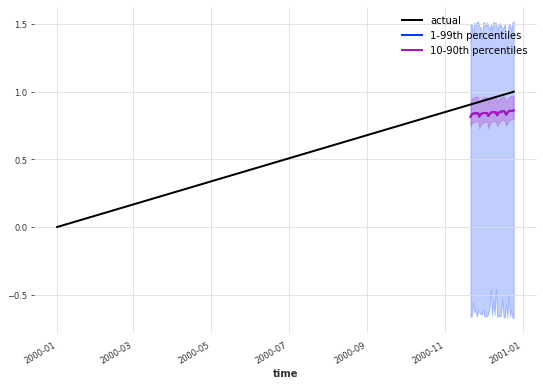

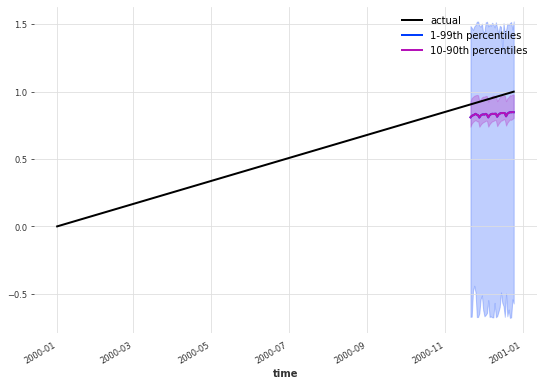

In [12]:
def eval_model(model, n, actual_series, train_series, val_series, future_covariates):
    pred_series = model.predict(n=n, series= train_series, future_covariates = future_covariates, num_samples=1000)

    figsize = (9, 6)
    lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
    label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
    label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
    
    # plot actual series

    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

#     plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

eval_model(model, pred_len, series_DE, train_DE, test_DE, covariates_DE)
eval_model(model, pred_len, series_AT, train_AT, test_AT, covariates_AT)

To generalize this example, if your actual data is coming from a dataframe, you can use the function `TimeSeries.from_group_dataframe` to create the needed list of time series. One can add the `group_cols` variable, and then add the static covariates with `.with_static_covariates` in a loop. There is a way to use the argument `static_covarariates` when calling `.from_group_dataframe`, but it was not 100% for me from the documentation how to use it correctly.

## 2. Toy example with multiple components of one time series
In this example, we don't have a list of time series for each of the static covariates, but we have one time series with multiple components, for example every component is a gmv of a certain country. We again add static covariates with `.with_static_covariates`, but using a different structure of the data frame containing the values.

In [13]:
ser_len = 360
countries_list = ['DE', 'AT', 'BE']

series = random_walk_timeseries(length=ser_len, column_name = f'gmv_{countries_list[0]}')
covariates = random_walk_timeseries(length=ser_len, column_name = f'discount_{countries_list[0]}')
covariates = covariates.stack(random_walk_timeseries(length=ser_len, column_name = f'weather_{countries_list[0]}'))

for i in range(1,len(countries_list)):
    series = series.stack(random_walk_timeseries(length=ser_len, column_name = f'gmv_{countries_list[i]}'))
    covariates = covariates.stack(random_walk_timeseries(length=ser_len, column_name = f'discount_{countries_list[i]}'))
    covariates = covariates.stack(random_walk_timeseries(length=ser_len, column_name = f'weather_{countries_list[i]}'))


In [14]:
# add component specific static covariates
static_covs = pd.DataFrame([[1., 0., 0.],[0., 1., 0.], [0., 0., 1.]], columns=countries_list)
static_covs_covs = pd.DataFrame([[1., 0., 0.],[1., 0., 0.],[0., 1., 0.],[0., 1., 0.],[0., 0., 1.],[0., 0., 1.]], columns=countries_list)

In [15]:
series = series.with_static_covariates(static_covs)
covariates = covariates.with_static_covariates(static_covs_covs)

In [16]:
series[1].static_covariates

static_covariates,DE,AT,BE
component,,,
gmv_DE,1.0,0.0,0.0
gmv_AT,0.0,1.0,0.0
gmv_BE,0.0,0.0,1.0


In [17]:
covariates[0].static_covariates

static_covariates,DE,AT,BE
component,,,
discount_DE,1.0,0.0,0.0
weather_DE,1.0,0.0,0.0
discount_AT,0.0,1.0,0.0
weather_AT,0.0,1.0,0.0
discount_BE,0.0,0.0,1.0
weather_BE,0.0,0.0,1.0


In [18]:
pred_len = 35
# Set aside the last X days as a test series
train, test = series[:-pred_len], series[-pred_len:]

In [19]:
quantiles = [0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]

model = TFTModel(input_chunk_length = pred_len,
                     output_chunk_length = pred_len,
                     hidden_size=64,
                     n_epochs = 150,
                     lstm_layers=2,
                     num_attention_heads=8,
                     dropout=0.1,
                     batch_size=32,
                     likelihood=QuantileRegression(quantiles=quantiles)
                )

In [20]:
model.fit(series=train, future_covariates=covariates, verbose=True) 

2022-07-16 09:34:59 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-07-16 09:34:59 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-16 09:34:59 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-16 09:34:59 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-07-16 09:34:59 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | static_covariates_vsn             | _VariableSelectionNetwork        | 5.1 K 
3  | encoder_vsn                       | _VariableSelectionNetwork        | 16.2 K
4  | decoder_vsn        

Epoch 149: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.55it/s, loss=0.619, train_loss=0.615]


In [21]:
prediction = model.predict(n=pred_len, series=train, future_covariates=covariates)

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, -272.39it/s]


In [22]:
component = 'gmv_DE'
wape = len(test[component])*100.0*mae(test[component], prediction[component]) / test[component].values().sum()
mape_val = mape(test[component], prediction[component])
print('*'*80)
print(f"Country {component}; WAPE: {wape}%")
print(f"Country {component}; MAPE: {mape_val}%")
print('*'*80)

********************************************************************************
Country gmv_DE; WAPE: 38.35314441607939%
Country gmv_DE; MAPE: 39.666515467013774%
********************************************************************************


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00, -3.25it/s]


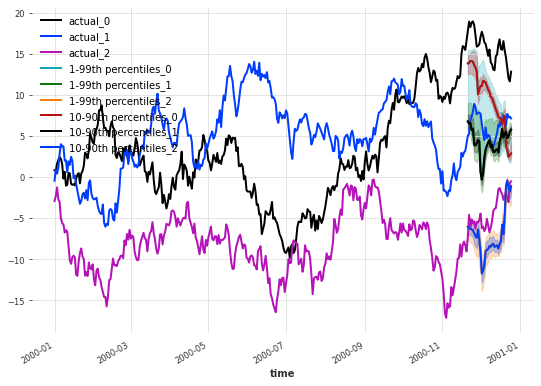

In [23]:
eval_model(model, pred_len, series, train, test, covariates)